## BGC-Chlorophyll Analysis
Here we conduct Analysis on BGC-CHLA analysis

In [130]:
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [131]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

df = df.filter(
    pl.col("CHLA")
    .is_not_null(  ))
#df.head()

#Filtering out data pre 2022
df = df.filter(
    pl.col("TIME") >= pl.datetime(2022,1,1)
)
df.write_parquet('../data/argo/Region/Regional_BGC-Argo_CHLA_Tablet(filtered).parquet')

# QC Filtering on CHLA_ADJUSTED data

df = df.filter(pl.col('CHLA_ADJUSTED_QC').is_in([1,2]))  # Keep only good and probably good data

# Adjusting CHLA values reducing by a a factor of 4
#df = df.with_columns(
#    (pl.col('CHLA_ADJUSTED') / 4).alias('CHLA_ADJUSTED')
#)

# Filtering after 500 dbar
df = df.filter(
    pl.col("PRES") <= 500
)
#Filtering out negative CHLA values
df = df.filter(
    pl.col("CHLA") >= 0
)

#Filtering out extreme CHLA values above 10 mg/m3
df = df.filter(
    pl.col("CHLA") <= 10
)

# Filtering Other region
df = df.filter(
    pl.col("region") != "Other"
)
df.write_parquet('../data/argo/Region/Regional_BGC-Argo_CHLA_Tablet(filtered).parquet')

### Depth Integrating CHL-a

In [132]:
# Creating a depth integrated Chlorophyll column dataframe

# Filtering the between 10m to 500m. (Including, typical euphotic zone depth and avoiding surface [<10m] Tanner et al. 2024)
# Sorting by Depth and profile
df_filtered = (
    df.filter((pl.col('PRES') >= 30) & (pl.col('PRES') <= 300))
      .sort(['PLATFORM_NUMBER', 'CYCLE_NUMBER', 'PRES'])
)

# Computing depth-integrated Chlorophyll per profile

# Compute depth-integrated CHL using trapezoidal rule per profile (also used in Tanner et al. 2024)
# Might be useful to integrate euphotic zone values
integrated = (
    df_filtered
    .group_by("PLATFORM_NUMBER", "CYCLE_NUMBER", maintain_order=True)
    .map_groups(lambda g: pl.DataFrame({
        "PLATFORM_NUMBER": [g["PLATFORM_NUMBER"][0]],
        "CYCLE_NUMBER": [g["CYCLE_NUMBER"][0]],
        "DEPTH_INT_CHL": [np.trapezoid(g["CHLA"].to_numpy(), # Trapezoid integration is consistant with other integration methods (Tanner et al. 2024))
                                   g["PRES"].to_numpy())]
    }))
)

# Subsurface Chlorophyll integrated

In [133]:
# Furher analysis and plotting can be done based on 'integrated' DataFrame
# Joining CHL replicating to dataframe
df = df.join(integrated, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME,region,DEPTH_INT_CHL
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns],str,f32
null,null,null,99999,"""""",99999,0.003148,0.003148,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.602454,0.786627,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,21.620001,21.620001,2.4,1,"""D""",1,35.01738,null,null,4,"""D""",4,9.041491,9.041491,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737
null,null,null,99999,"""""",99999,0.003079,0.003079,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.74762,0.85921,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,22.219999,22.219999,2.4,1,"""D""",1,35.016781,null,null,4,"""D""",4,9.035191,9.035191,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737
null,null,null,99999,"""""",99999,0.00295,0.00295,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.48336,0.72708,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,22.92,22.92,2.4,1,"""D""",1,35.016079,null,null,4,"""D""",4,9.027841,9.027841,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737
null,null,null,99999,"""""",99999,0.003083,0.003083,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.51913,0.744965,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,23.52,23.52,2.4,1,"""D""",1,35.012619,null,null,4,"""D""",4,8.99684,8.99684,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737
null,null,null,99999,"""""",99999,0.003102,0.003102,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.503174,0.736987,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,24.120001,24.120001,2.4,1,"""D""",1,35.00872,null,null,4,"""D""",4,8.96204,8.96204,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737


In [134]:
# Keep one row per profile for climatology
profiles = (
    df
    .select([
        "PLATFORM_NUMBER",
        "CYCLE_NUMBER",
        "DEPTH_INT_CHL",
        "TIME",        # adjust name if your time column is different
        "LATITUDE",
        "LONGITUDE",
        "region",
        "PRES"
    ])
    .unique(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .filter(pl.col("DEPTH_INT_CHL").is_not_null())
)

# Adding month to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.month().alias("month")   # 1–12
)

# Adding Week to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.week().alias("week")   # 1–52
)


### Assesing Profile nº 

<Figure size 1000x600 with 0 Axes>

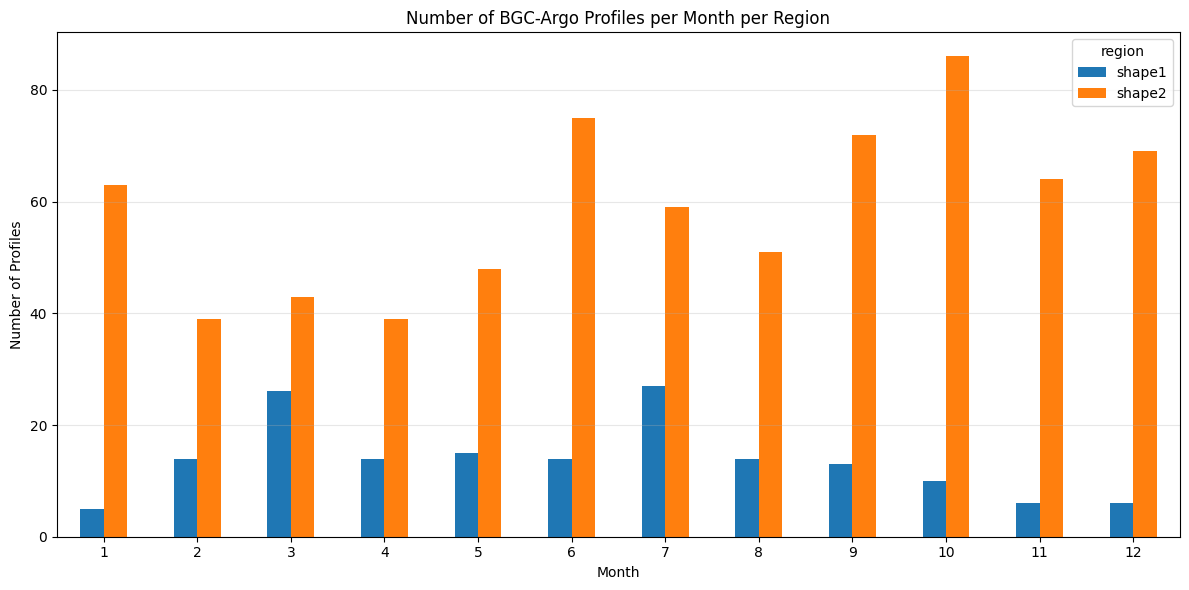

<Figure size 1200x600 with 0 Axes>

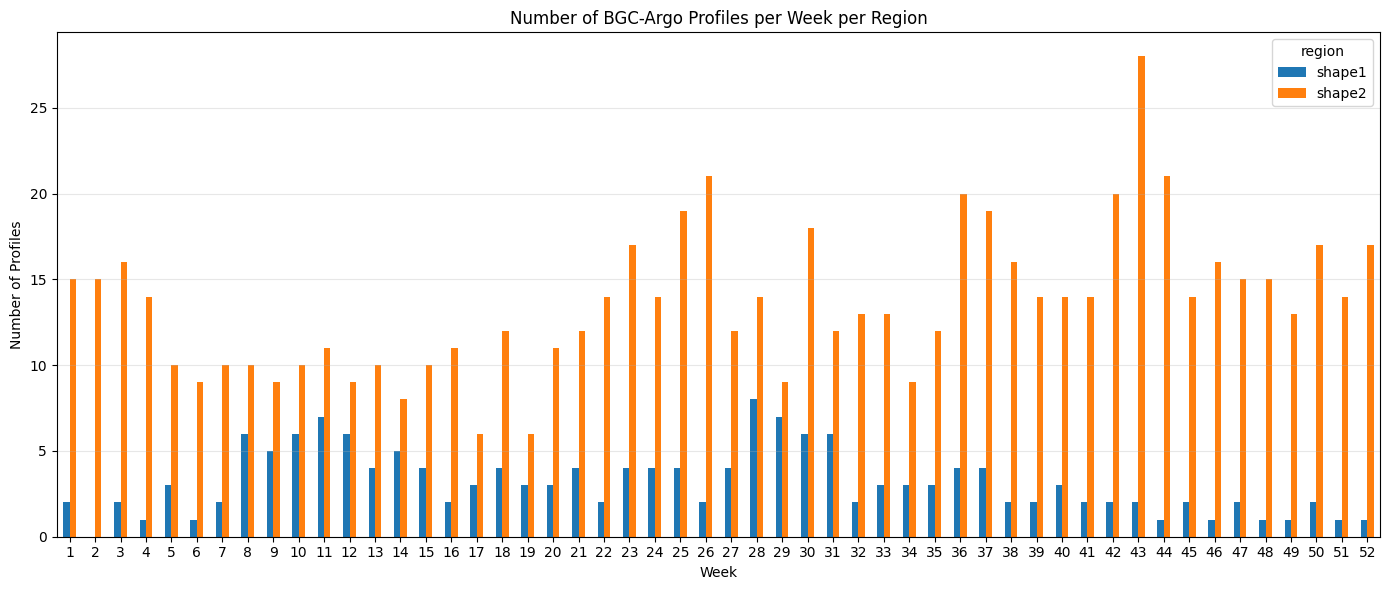

In [135]:
# Plottinhg number of profiles per month and week per region
profiles_per_month = (
    profiles
    .group_by("region","month")
    .agg(
        pl.len().alias("n_profiles")
    )
    .sort("month")
)


ppm = profiles_per_month.to_pandas()

# Pivot to wide format for grouped bars
ppm_wide = ppm.pivot(index="month", columns="region", values="n_profiles")

plt.figure(figsize=(10, 6))

ppm_wide.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Month")
plt.ylabel("Number of Profiles")
plt.title("Number of BGC-Argo Profiles per Month per Region")
plt.xticks(ticks=range(0, 12), labels=range(1, 13), rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

profiles_per_week = (
    profiles
    .group_by("region","week")
    .agg(
        pl.len().alias("n_profiles")
    )
    .sort("week")
)

ppw = profiles_per_week.to_pandas()

# Pivot to wide format for grouped bars
ppw_wide = ppw.pivot(index="week", columns="region", values="n_profiles")

plt.figure(figsize=(12, 6))
ppw_wide.plot(kind="bar", figsize=(14, 6))
plt.xlabel("Week")
plt.ylabel("Number of Profiles")
plt.title("Number of BGC-Argo Profiles per Week per Region")
plt.xticks(ticks=range(0, 52), labels=range(1, 53), rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()


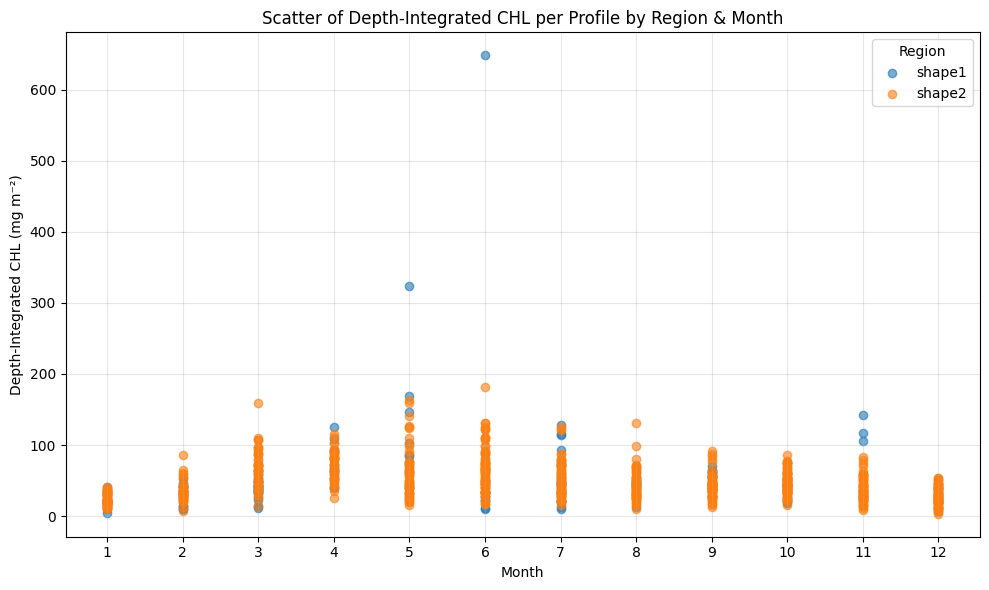

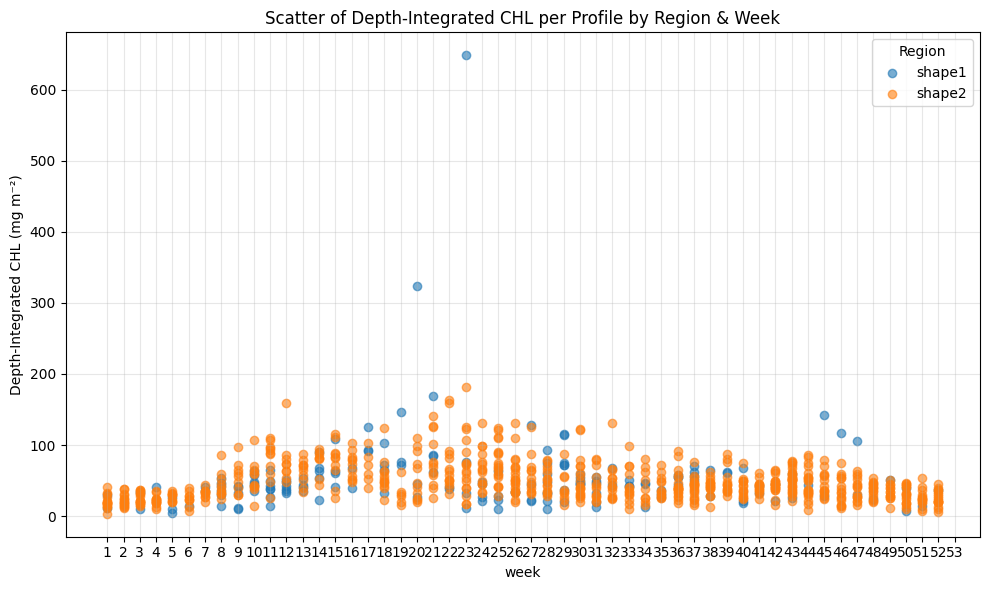

In [136]:
profiles_pd = profiles.to_pandas()

plt.figure(figsize=(10,6))

# Scatter: month on x, depth-integrated CHL on y, colour by region
for region_name, grp in profiles_pd.groupby("region"):
    plt.scatter(
        grp["month"], 
        grp["DEPTH_INT_CHL"], 
        alpha=0.6, 
        label=region_name
    )

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Depth-Integrated CHL (mg m⁻²)")
plt.title("Scatter of Depth-Integrated CHL per Profile by Region & Month")
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
# Scatter: month on x, depth-integrated CHL on y, colour by region
for region_name, grp in profiles_pd.groupby("region"):
    plt.scatter(
        grp["week"], 
        grp["DEPTH_INT_CHL"], 
        alpha=0.6, 
        label=region_name
    )

plt.xticks(range(1,54))
plt.xlabel("week")
plt.ylabel("Depth-Integrated CHL (mg m⁻²)")
plt.title("Scatter of Depth-Integrated CHL per Profile by Region & Week")
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

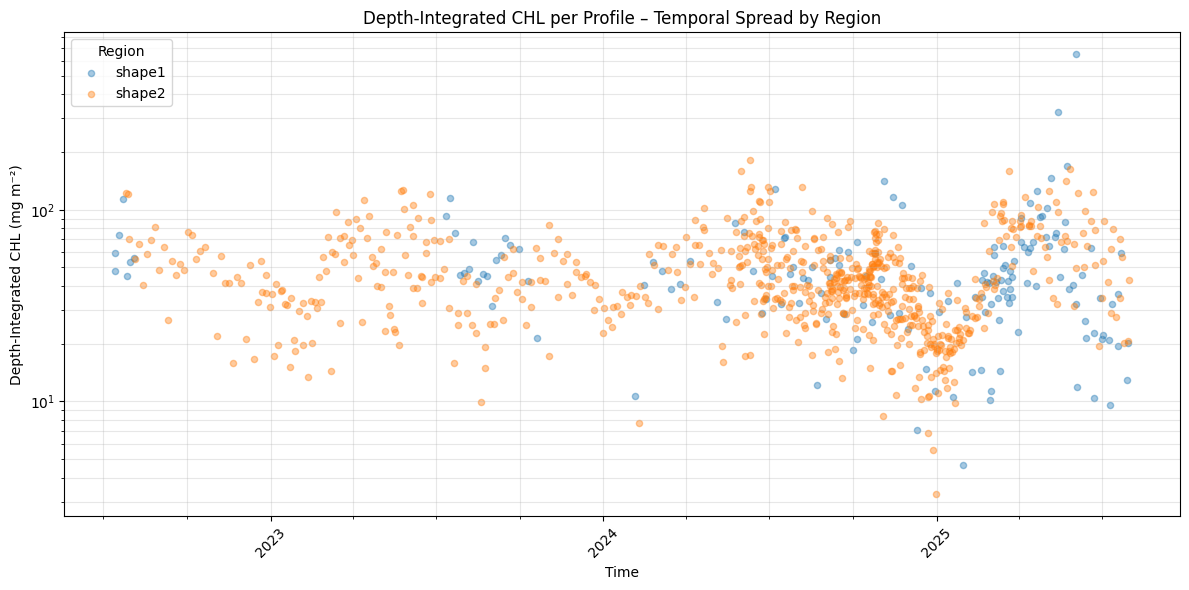

In [137]:
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 6))

for region_name, grp in profiles_pd.groupby("region"):
    plt.scatter(
        grp["TIME"], 
        grp["DEPTH_INT_CHL"], 
        alpha=0.4, 
        label=region_name,
        s=20
    )

plt.yscale("log")  # use log scale if values vary a lot
plt.xlabel("Time")
plt.ylabel("Depth-Integrated CHL (mg m⁻²)")
plt.title("Depth-Integrated CHL per Profile – Temporal Spread by Region")

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())        # major tick every year
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))  # minor tick every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.legend(title="Region")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

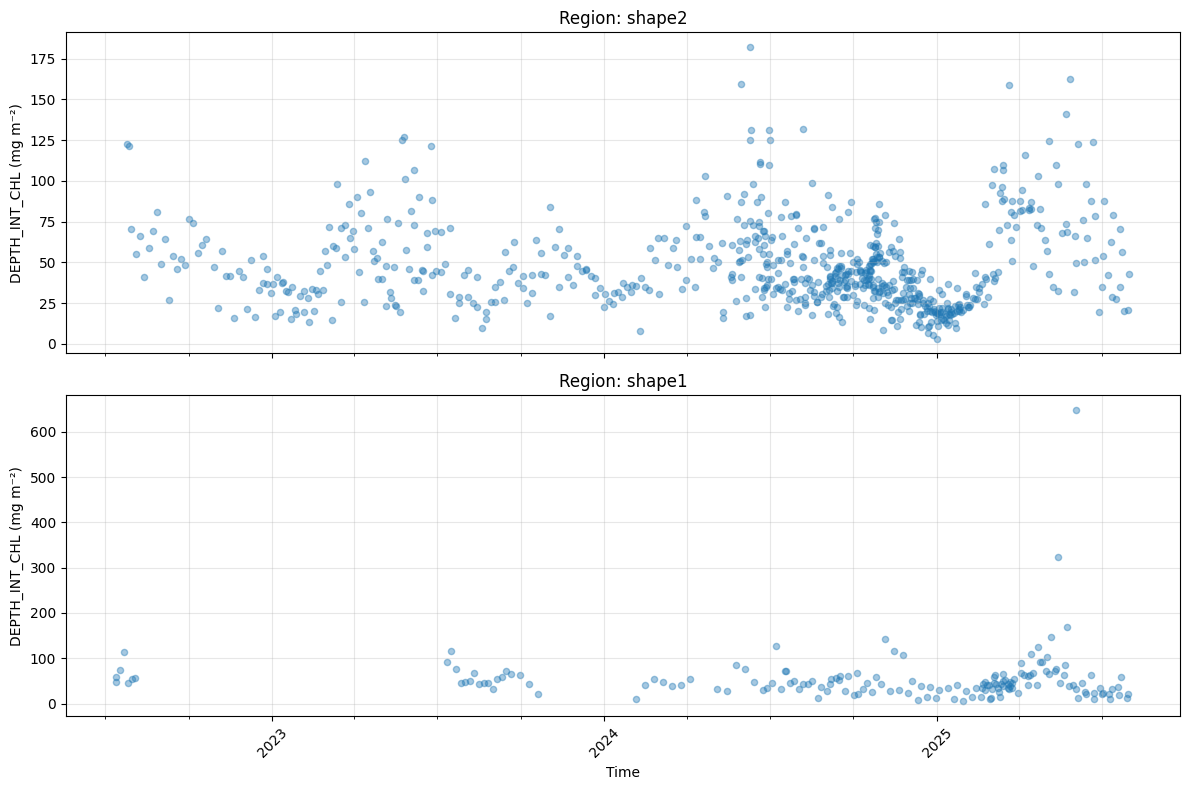

In [138]:
regions = profiles_pd["region"].unique()
n = len(regions)
fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = profiles_pd[profiles_pd["region"] == region_name]
    ax.scatter(
        grp["TIME"],
        grp["DEPTH_INT_CHL"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("DEPTH_INT_CHL (mg m⁻²)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)

# Common x-axis formatting
axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

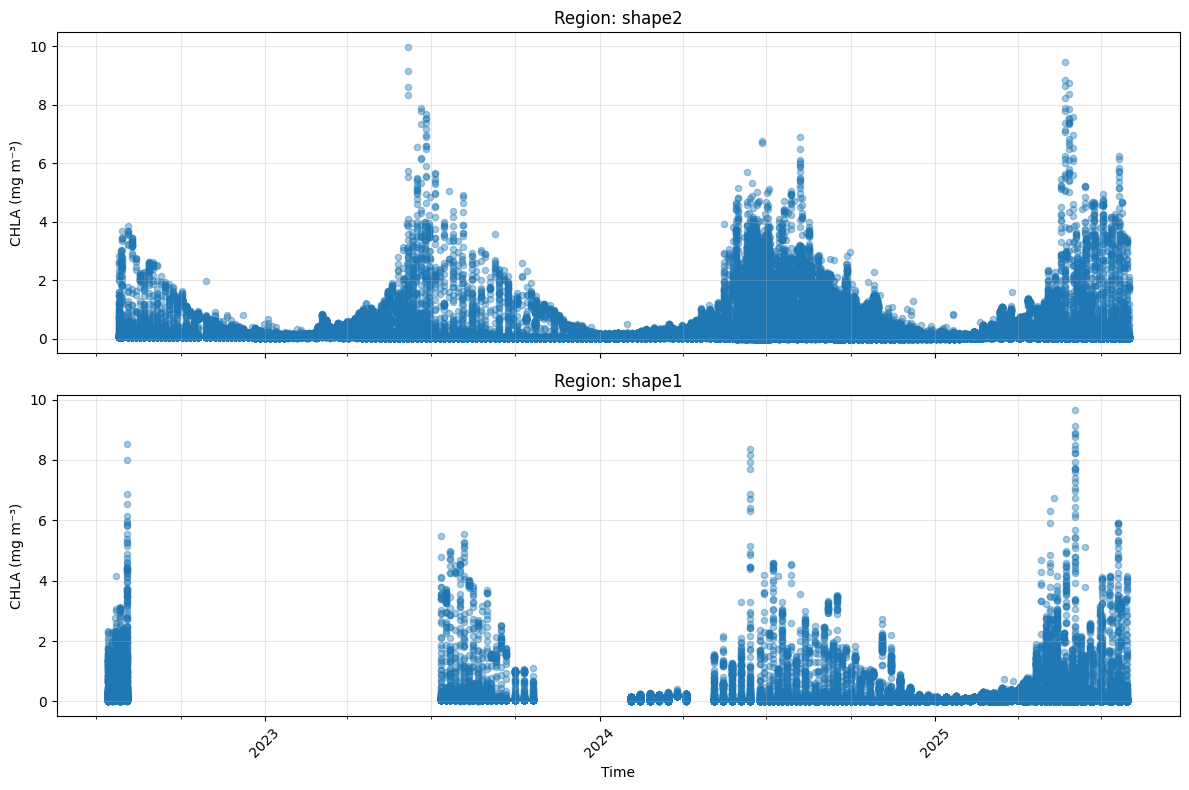

In [139]:
pres_plot = df.select("PLATFORM_NUMBER", "CYCLE_NUMBER", "TIME", "PRES", "CHLA", "region").to_pandas()

fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = pres_plot[pres_plot["region"] == region_name]
    ax.scatter(
        grp["TIME"],
        grp["CHLA"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("CHLA (mg m⁻³)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)


# Common x-axis formatting
axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

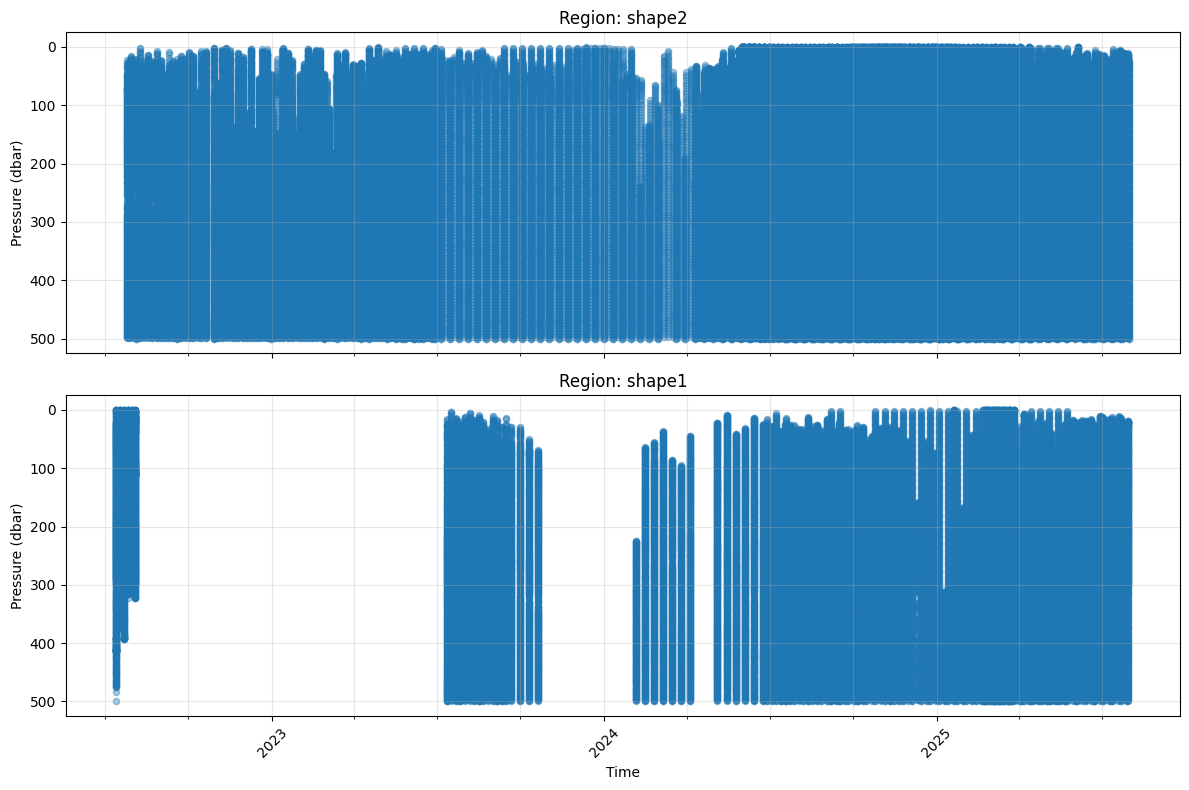

In [140]:
# Filtering variables and plotting Pressure profiles per region (asses depth coverage)

fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = pres_plot[pres_plot["region"] == region_name]
    ax.scatter(
        grp["TIME"],
        grp["PRES"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("Pressure (dbar)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)

    ax.invert_yaxis()

# Common x-axis formatting
axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

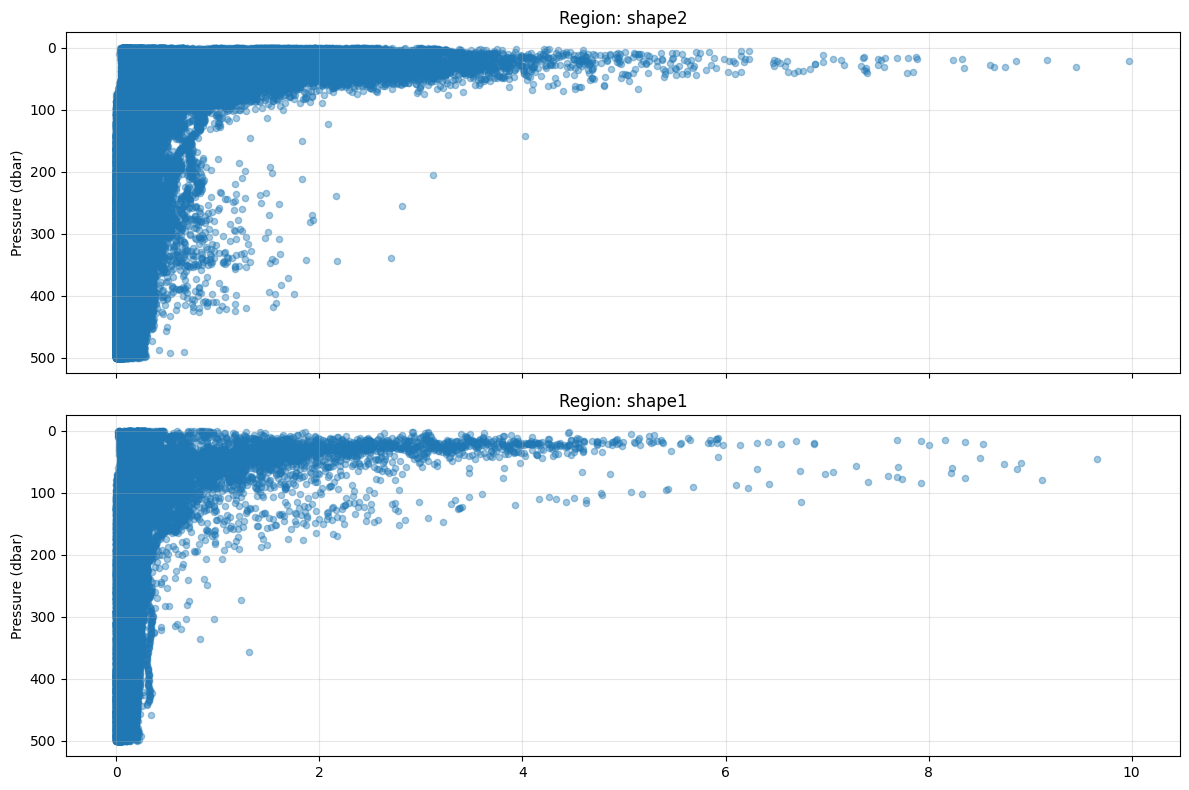

In [141]:
fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = pres_plot[pres_plot["region"] == region_name]
    ax.scatter(
        grp["CHLA"],
        grp["PRES"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("Pressure (dbar)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)

    ax.invert_yaxis()

plt.tight_layout()
plt.show()

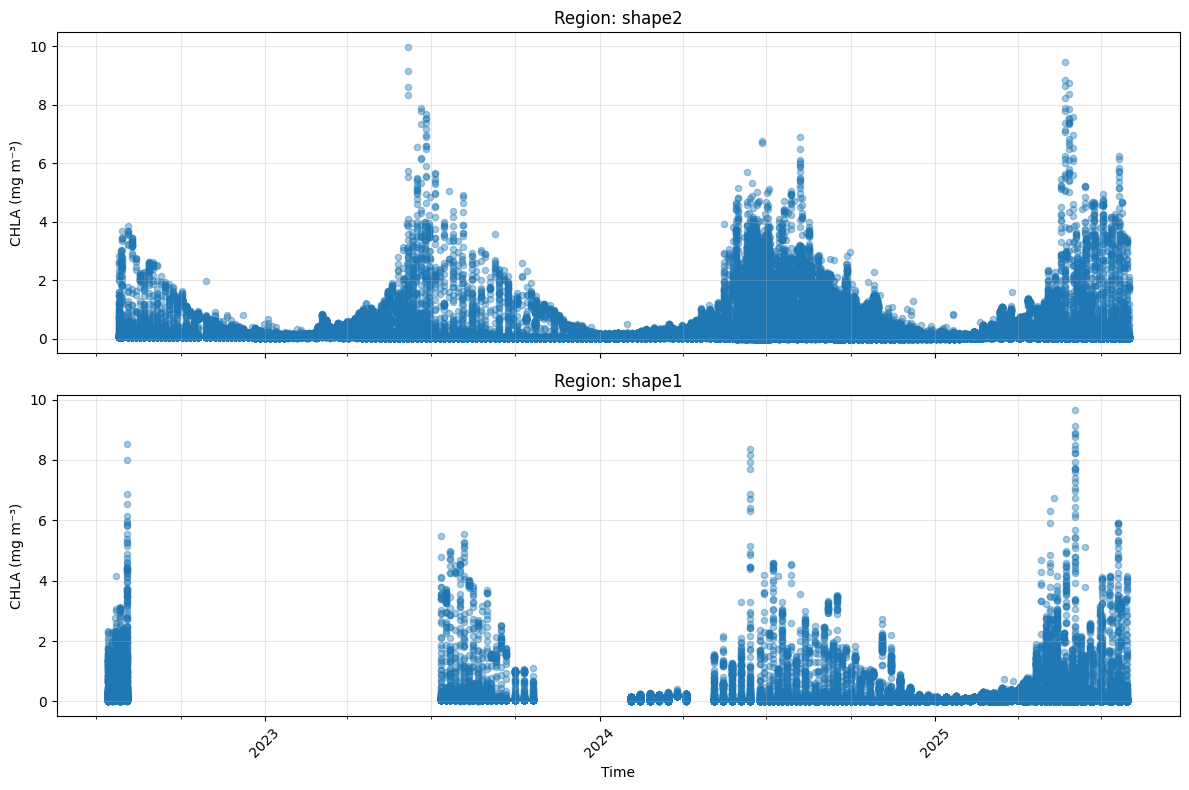

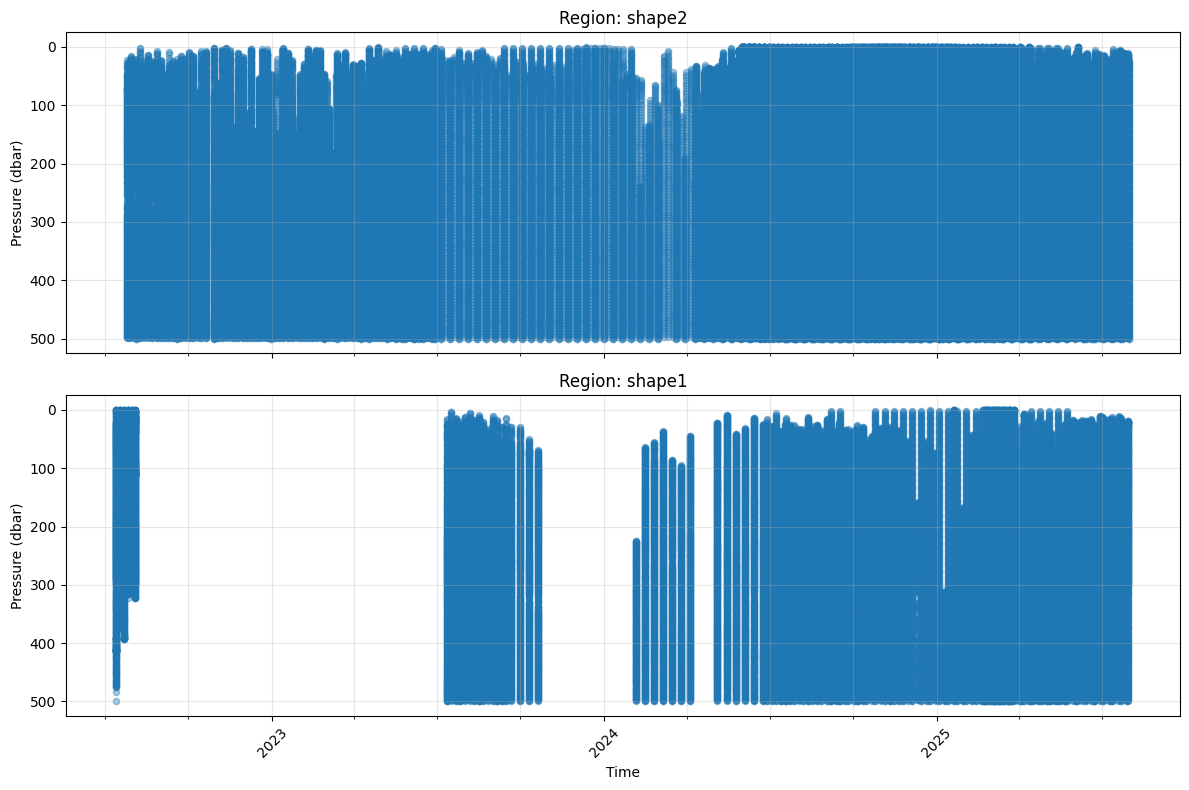

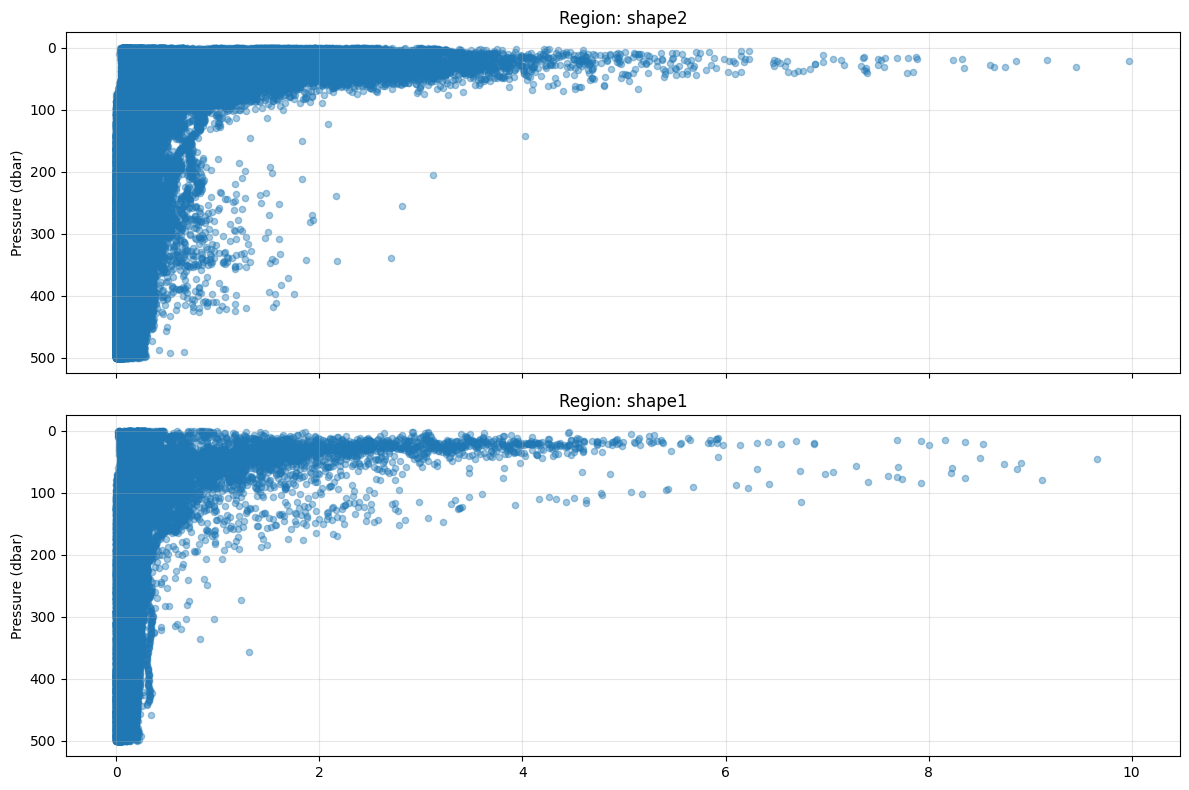

In [142]:
# Filtering by post 2022 data
pres_plot = pres_plot[pres_plot["TIME"] >= "2022-01-01"]

fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = pres_plot[pres_plot["region"] == region_name]
    ax.scatter(
        grp["TIME"],
        grp["CHLA"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("CHLA (mg m⁻³)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)


# Common x-axis formatting
axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# Filtering variables and plotting Pressure profiles per region (asses depth coverage)

fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = pres_plot[pres_plot["region"] == region_name]
    ax.scatter(
        grp["TIME"],
        grp["PRES"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("Pressure (dbar)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)

    ax.invert_yaxis()

# Common x-axis formatting
axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

for ax, region_name in zip(axes, regions):
    grp = pres_plot[pres_plot["region"] == region_name]
    ax.scatter(
        grp["CHLA"],
        grp["PRES"],
        alpha=0.4,
        s=20
    )
    #ax.set_yscale("log")
    ax.set_ylabel("Pressure (dbar)")
    ax.set_title(f"Region: {region_name}")
    ax.grid(True, which="both", alpha=0.3)

    ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Creating A CHL-a Climatology

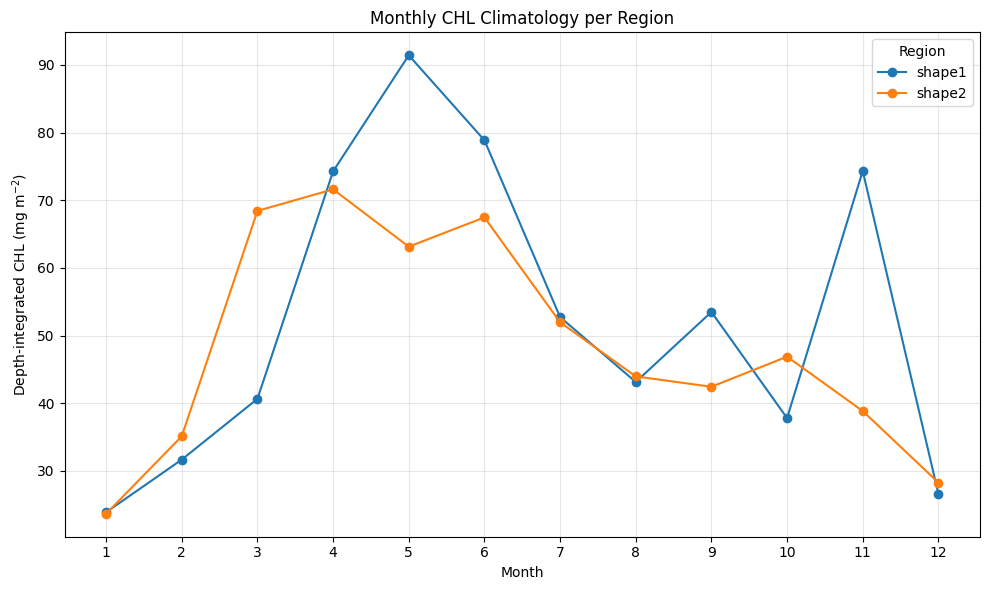

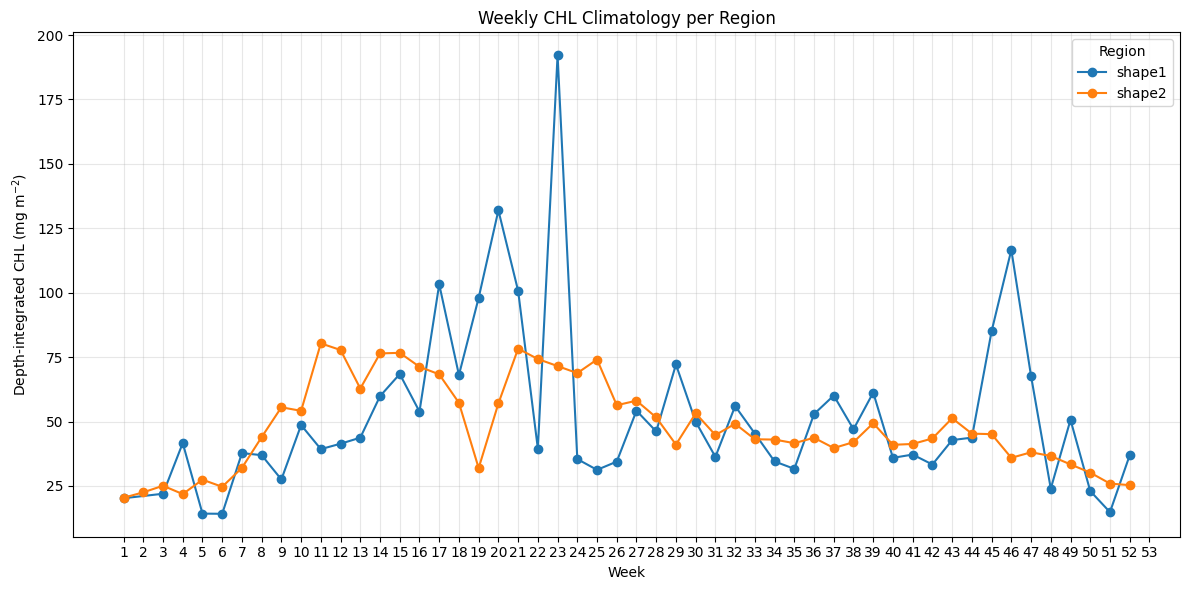

In [143]:


monthly_clim = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
clim_pd = monthly_clim.to_pandas()
climw_pd = week_clim.to_pandas()

plt.figure(figsize=(10, 6))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["month"],
    #    group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2,
    #)

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Monthly CHL Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["week"],
    #    group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2,
    #)
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")    
plt.title("Weekly CHL Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### Euphotic zone integration
Calculating Euphotic zone based on Morel & Maritonera 2001

In [144]:
# Estimating CHL based on Morel & Maritorena (2001) Zeu–CHL relationship

# Computng Surface CHL

surface_chl = (
    df
    .filter(pl.col('PRES_ADJUSTED') <= 20)  # Surface defined as 0-20m
    .group_by("PLATFORM_NUMBER", "CYCLE_NUMBER","region")
    .agg(
        pl.col("CHLA_ADJUSTED").mean().alias("SURFACE_CHL")
    )
)

# Computing Zeu using Morel empirical model

def compute_zeu(surf_chl: pl.Expr) -> pl.Expr:
    """
    Vectorised Zeu computation using a Morel-style power-law on SURFACE_CHL.
    NOTE: This uses surface CHL (mg m^-3), not integrated C_tot (mg m^-2).
    """
    return (
        pl.when(surf_chl > 0.1)
          .then(912.5 * surf_chl.pow(-0.839))
          .when((surf_chl > 0) & (surf_chl <= 0.1))
          .then(426.3 * surf_chl.pow(-0.547))
          .otherwise(None)  # For CHL <= 0 or missing
          .alias("ZEU_MOREL")
    )

surface_chl = surface_chl.with_columns(
    compute_zeu(pl.col("SURFACE_CHL"))
)
surface_chl.head
# --- STEP 3: join Zeu back to original dataframe ---
df_zeu = df.join(
    surface_chl,
    on=["PLATFORM_NUMBER", "CYCLE_NUMBER"],
    how="left"
)


df_zeu.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME,region,DEPTH_INT_CHL,region_right,SURFACE_CHL,ZEU_MOREL
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns],str,f32,str,f32,f32
null,null,null,99999,"""""",99999,0.003148,0.003148,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.602454,0.786627,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,21.620001,21.620001,2.4,1,"""D""",1,35.01738,null,null,4,"""D""",4,9.041491,9.041491,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737,null,null,null
null,null,null,99999,"""""",99999,0.003079,0.003079,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.74762,0.85921,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,22.219999,22.219999,2.4,1,"""D""",1,35.016781,null,null,4,"""D""",4,9.035191,9.035191,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737,null,null,null
null,null,null,99999,"""""",99999,0.00295,0.00295,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.48336,0.72708,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,22.92,22.92,2.4,1,"""D""",1,35.016079,null,null,4,"""D""",4,9.027841,9.027841,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737,null,null,null
null,null,null,99999,"""""",99999,0.003083,0.003083,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.51913,0.744965,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,23.52,23.52,2.4,1,"""D""",1,35.012619,null,null,4,"""D""",4,8.99684,8.99684,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737,null,null,null
null,null,null,99999,"""""",99999,0.003102,0.003102,null,3,"""A""",3,null,null,null,99999,"""""",99999,0.732,null,null,0,"""R""",0,1.503174,0.736987,null,2,"""A""",3,1,null,null,null,99999,"""""",99999,…,"""""",99999,null,null,null,99999,"""""",99999,6903579,1,24.120001,24.120001,2.4,1,"""D""",1,35.00872,null,null,4,"""D""",4,8.96204,8.96204,0.002,8,"""D""",8,1,65.8887,-28.488012,2022-07-13 17:13:00,"""shape1""",59.506737,null,null,null


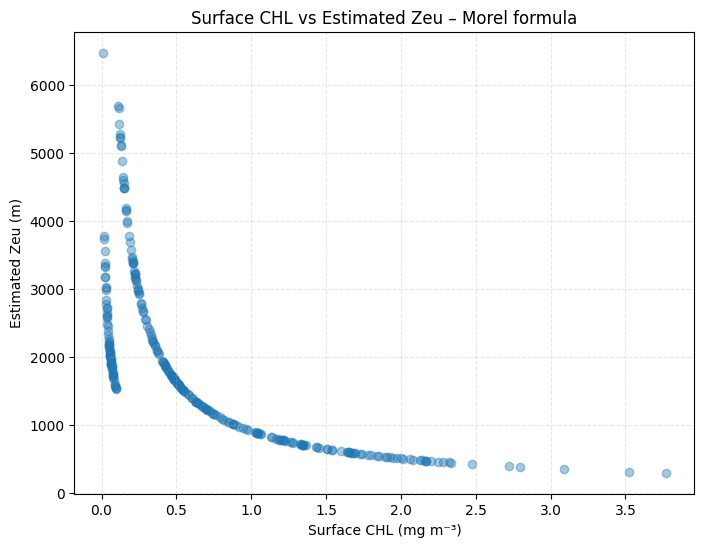

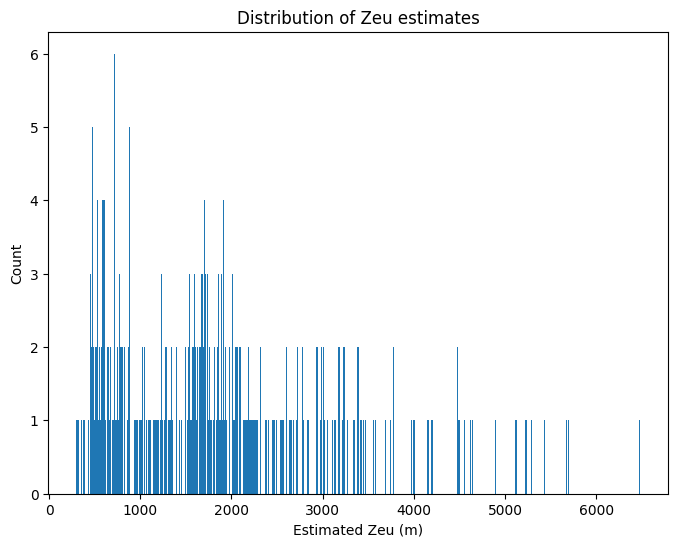

In [145]:
sc = surface_chl.to_pandas()

plt.figure(figsize=(8,6))
plt.scatter(sc["SURFACE_CHL"], sc["ZEU_MOREL"], alpha=0.4)

plt.xlabel("Surface CHL (mg m⁻³)")
plt.ylabel("Estimated Zeu (m)")
plt.title("Surface CHL vs Estimated Zeu – Morel formula")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(sc["ZEU_MOREL"].dropna(), bins=500)
plt.xlabel("Estimated Zeu (m)")
plt.ylabel("Count")
plt.title("Distribution of Zeu estimates")
plt.show()

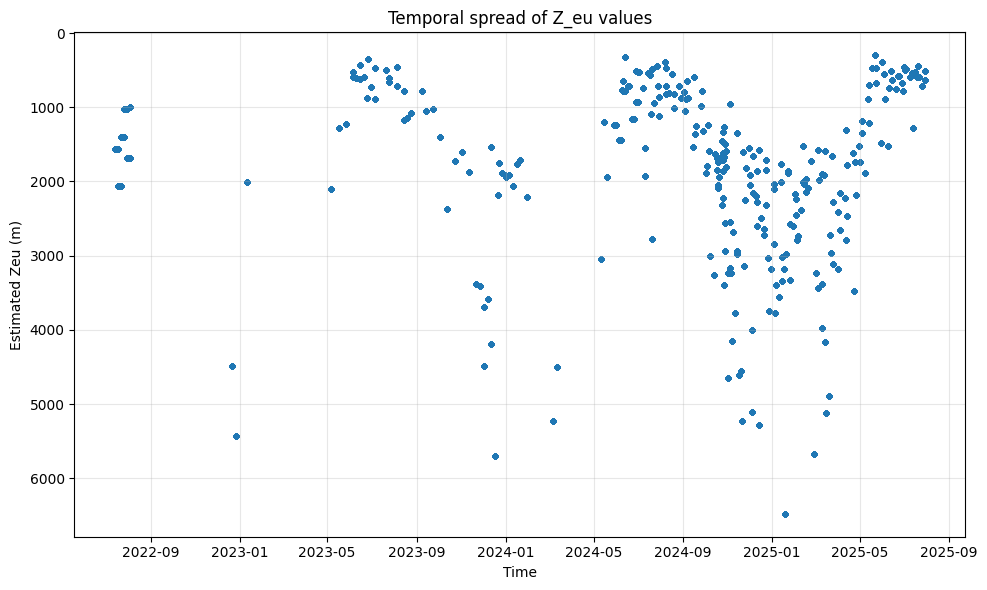

In [146]:
# Suppose you have df_zeu with TIME and ZEU_MOREL
df_plot = df_zeu.select(["TIME", "ZEU_MOREL"]).drop_nulls().to_pandas()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"])

plt.figure(figsize=(10,6))
plt.scatter(df_plot["TIME"], df_plot["ZEU_MOREL"], alpha=0.4, s=10)
plt.xlabel("Time") 
plt.gca().invert_yaxis()
plt.ylabel("Estimated Zeu (m)")
plt.title("Temporal spread of Z_eu values")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_23594/2123504644.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


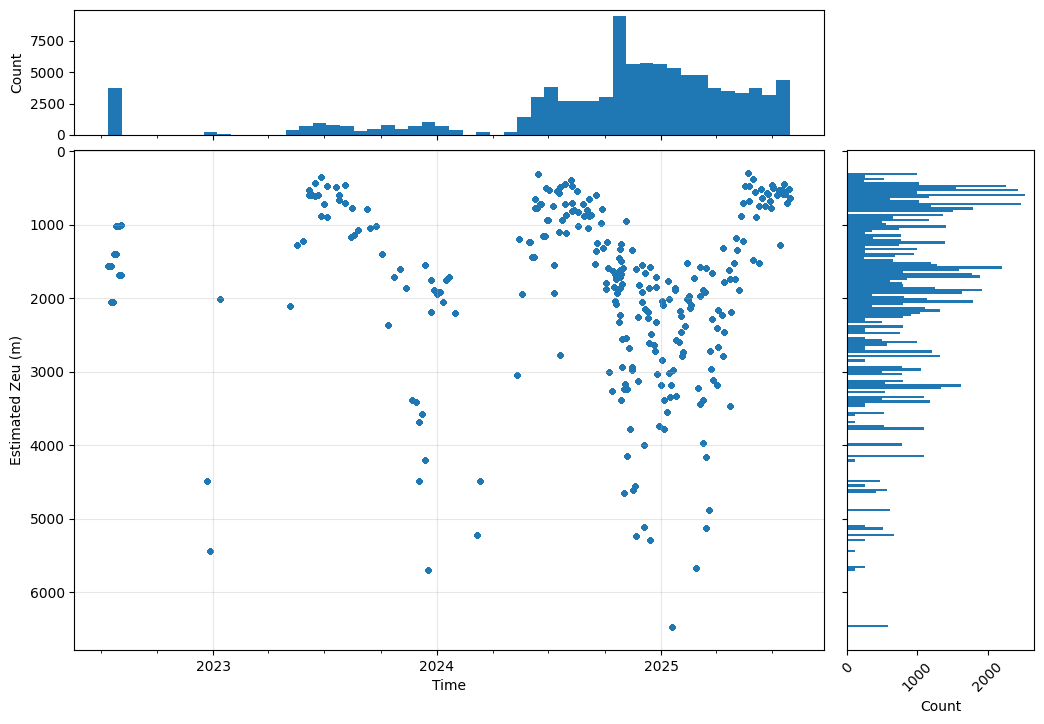

In [147]:
df_plot = df_zeu.select(["TIME", "ZEU_MOREL"]).drop_nulls().to_pandas()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"])
x = df_plot["TIME"]
y = df_plot["ZEU_MOREL"]

# Define figure and axes layout using gridspec
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx   = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot: time vs Zeu
ax_scatter.scatter(x, y, alpha=0.4, s=10)
ax_scatter.set_xlabel("Time")
ax_scatter.set_ylabel("Estimated Zeu (m)")
ax_scatter.invert_yaxis()       # if you want larger depths at bottom
ax_scatter.grid(True, alpha=0.3)

# Histogram on top: distribution of times (optional)
ax_histx.hist(x, bins=50)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_ylabel("Count")

# Histogram on right: distribution of Zeu values
ax_histy.hist(y, bins=200, orientation='horizontal')
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xlabel("Count")

# Format time axis
ax_scatter.xaxis.set_major_locator(mdates.YearLocator())
ax_scatter.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax_scatter.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()